In [1]:
#Dataset is uploaded to gdrive, so will be mounting my drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# changing working directory to the dataset directory
import os
os.chdir('drive/My Drive') 

In [3]:
# importing the required libraries for data pre-processing and model traning
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling2D, Dense, Dropout, Input, Flatten
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt  
import seaborn as sns

from imutils import paths
import random
import pickle
import cv2
import csv
import shutil
import numpy as np

# random.seed(42) #To get same random values each time

#to Load Truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#Input model dimensions
img_width = 128
img_height = 128
dataset = './dataset'

In [5]:
# initialize the data and labels
data = []
labels = []

# grab the image paths of all input images to model and randomly shuffle them
imagePaths = sorted(list(paths.list_images(dataset))) 
random.shuffle(imagePaths)

for imagePath in imagePaths:
    img = image.load_img(imagePath, target_size=(img_width, img_height,3))
    img = img_to_array(img)
    img = img / 255.0
    data.append(img)
    
    # extract set of class labels from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    if label == "healthy":
      label = 1
    elif label == "cracked":
      label = 0
    labels.append(label)
    
#Convert labels and data in numpy arrays
data = np.array(data)
labels = np.array(labels)

In [6]:
# partition the data into training  80% and testing 20% splits
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=42)

# construct the image generator for data augmentation (Data is very less, this will improve the model)
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	                      horizontal_flip=True, fill_mode="nearest")

In [7]:
 #Applying Transfer Learning 
base_model = ResNet50(input_shape=data[0].shape, include_top=False, weights='imagenet')
base_model.trainable = True #Allowing model to trainable (as data is too less)
base_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
__________________________

In [8]:
res_mod = base_model.output
res_mod = AveragePooling2D(pool_size=(4,4))(res_mod)
res_mod = Flatten(name="flatten")(res_mod)
res_mod = Dense(256, activation="relu")(res_mod)
res_mod = Dropout(0.5)(res_mod)
res_mod = Dense(1, activation='sigmoid')(res_mod)

In [9]:
model = Model(inputs=base_model.input, outputs=res_mod)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
# initialize the number of epochs to train for, initia learning rate, and batch size
Epochs = 250
learning_rate = 1e-4
batch_size = 16

In [11]:
opt = Adam(lr= learning_rate, decay= learning_rate / Epochs)
model.compile(optimizer=opt, loss= "binary_crossentropy", metrics=["accuracy"])

from tensorflow.keras.callbacks import EarlyStopping
# Early Stopping If model is not improving on validation set
stop = EarlyStopping(monitor="val_accuracy", min_delta=0.00001, patience=15, restore_best_weights=True)

#Training the model for 250 epochs
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(testX, testY), epochs=Epochs, callbacks=[stop])

Epoch 1/250
12/12 [==============================] - 3s 282ms/step - loss: 0.8579 - accuracy: 0.5053 - val_loss: 0.7703 - val_accuracy: 0.4792
Epoch 2/250
12/12 [==============================] - 1s 97ms/step - loss: 0.5392 - accuracy: 0.7211 - val_loss: 0.6962 - val_accuracy: 0.5208
Epoch 3/250
12/12 [==============================] - 1s 85ms/step - loss: 0.5213 - accuracy: 0.7474 - val_loss: 1.2695 - val_accuracy: 0.5208
Epoch 4/250
12/12 [==============================] - 1s 83ms/step - loss: 0.3617 - accuracy: 0.8579 - val_loss: 2.2743 - val_accuracy: 0.5208
Epoch 5/250
12/12 [==============================] - 1s 84ms/step - loss: 0.3538 - accuracy: 0.8526 - val_loss: 2.0486 - val_accuracy: 0.5208
Epoch 6/250
12/12 [==============================] - 1s 84ms/step - loss: 0.3074 - accuracy: 0.8842 - val_loss: 2.9162 - val_accuracy: 0.5208
Epoch 7/250
12/12 [==============================] - 1s 86ms/step - loss: 0.2296 - accuracy: 0.9263 - val_loss: 2.4244 - val_accuracy: 0.5208
Epoch

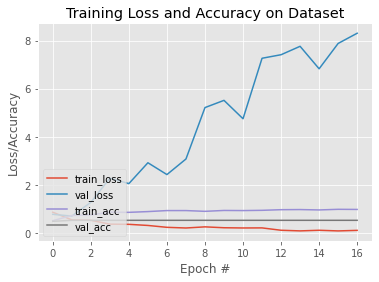

In [12]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
#Model stopped improvement at 26 steps so training is stopped at that point
Epochs = 17

plt.plot(np.arange(0, Epochs), H.history["loss"], label= "train_loss")
plt.plot(np.arange(0, Epochs), H.history["val_loss"], label= "val_loss")
plt.plot(np.arange(0, Epochs), H.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, Epochs), H.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [13]:
#Calculating Model's Accuracy on Test Data
results = model.evaluate(testX, testY, batch_size=4)
print('test loss, test acc:', results)

12/12 [==============================] - 0s 9ms/step - loss: 0.6962 - accuracy: 0.5208
test loss, test acc: [0.6962103843688965, 0.5208333134651184]


In [15]:
#Will be designing the model in TensorFlow based Keras package
Y_pred = model.predict_generator(testX, 48 // 4)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(testY, y_pred)
print(cm)
print('Classification Report')
print(classification_report(testY, y_pred))

Confusion Matrix
[[23  0]
 [25  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        23
           1       0.00      0.00      0.00        25

    accuracy                           0.48        48
   macro avg       0.24      0.50      0.32        48
weighted avg       0.23      0.48      0.31        48



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
